In [17]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import multiprocessing

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy/'))
sc.logging.print_versions()

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


In [18]:
# # read in the data
mature = sc.read_h5ad('/home/jovyan/Ben/Mature_Immune_v2.1.h5ad')
mature

AnnData object with n_obs × n_vars = 7803 × 33694 
    obs: 'celltype', 'compartment', 'Experiment', 'Project'
    var: 'ID'
    obsm: 'X_umap'

In [19]:
fetal = sc.read_h5ad('/home/jovyan/Ben/Fetal_immune.h5ad')
fetal

AnnData object with n_obs × n_vars = 6847 × 33694 
    obs: 'Barcode', 'Short_Sample', 'Experiment', 'Gender', 'Age', 'Stage', 'Selection', 'celltype', 'compartment'
    var: 'ID'
    obsm: 'X_umap'

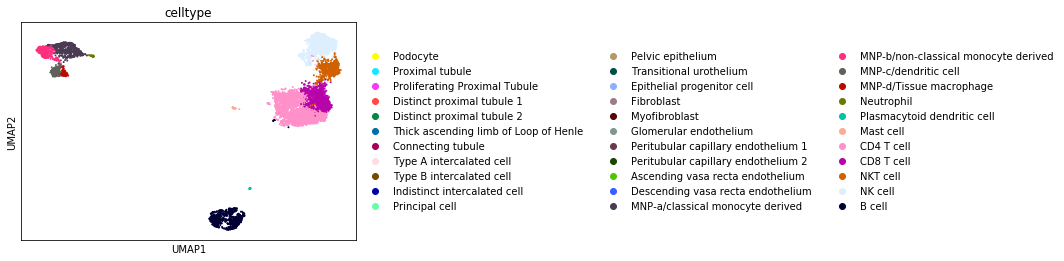

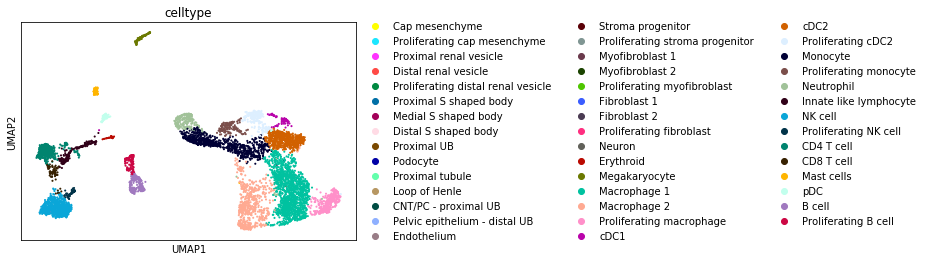

In [20]:
sc.pl.umap(mature, color = 'celltype')
sc.pl.umap(fetal, color = 'celltype')

In [25]:
# subset to just the B-related cells
mature = mature[mature.obs['celltype'].isin(['MNP-a/classical monocyte derived', 'MNP-b/non-classical monocyte derived', 'MNP-c/dendritic cell', 'MNP-d/Tissue macrophage'])]
fetal = fetal[fetal.obs['celltype'].isin(['Macrophage 1', 'Macrophage 2', 'Proliferating macrophage', 'cDC1', 'cDC2', 'Proliferating cDC2', 'Monocyte', 'Proliferating monocyte'])]

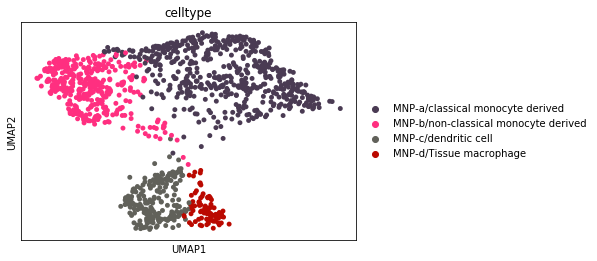

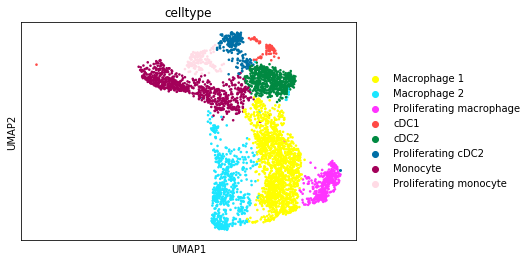

In [27]:
sc.pl.umap(mature, color = ['celltype'], ncols = 3)
sc.pl.umap(fetal, color = ['celltype'], ncols = 3)

In [28]:
mature_file = 'dataset/kidney_mature_mnp.h5ad'
fetal_file = 'dataset/kidney_fetal_mnp.h5ad'

mature.write(mature_file, compression = 'gzip')
fetal.write(fetal_file, compression = 'gzip')

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

mature_file = 'dataset/kidney_mature_mnp.h5ad'
fetal_file = 'dataset/kidney_fetal_mnp.h5ad'

mature = sc.read_h5ad(mature_file)
fetal = sc.read_h5ad(fetal_file)

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
def bh(pvalues):
    '''
    Computes the Benjamini-Hochberg FDR correction.
    
    Input:
        * pvals - vector of p-values to correct
    '''
    n = int(pvalues.shape[0])
    new_pvalues = np.empty(n)
    values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]
    values.sort()
    values.reverse()
    new_values = []
    for i, vals in enumerate(values):
        rank = n - i
        pvalue, index = vals
        new_values.append((n/rank) * pvalue)
    for i in range(0, int(n)-1):
        if new_values[i] < new_values[i+1]:
            new_values[i+1] = new_values[i]
    for i, vals in enumerate(values):
        pvalue, index = vals
        new_pvalues[index] = new_values[i]
    return new_pvalues

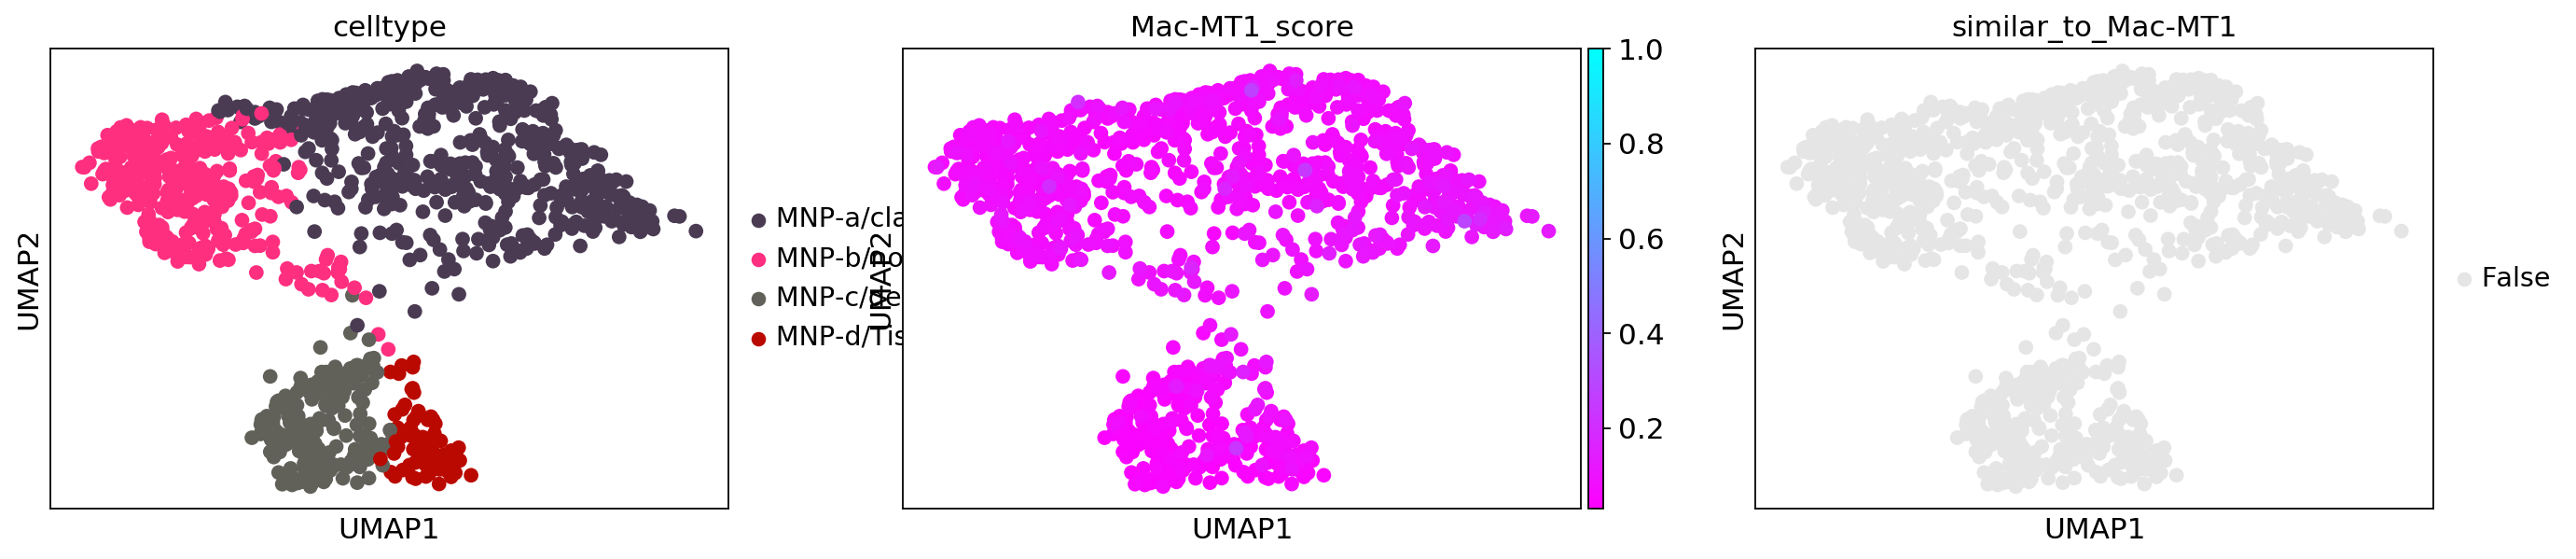

In [3]:
# now compute Mac-MT1 score p-values. figure out the global median and mad (from above-median values) for the distribution for each celltype
med = np.median(mature.obs['Mac-MT1_score'])
mask = mature.obs['Mac-MT1_score']>med
mad = np.median(mature.obs['Mac-MT1_score'][mask]-med)
# do a one-sided test with Krystoff's implementation
pvals = 1-scipy.stats.norm.cdf(mature.obs['Mac-MT1_score'], loc=med, scale=1.4826*mad)
mature.obs['bh_pval'] = bh(pvals)
# threshold the p-values to get potential Mac-MT1 calls.
mature.obs['similar_to_Mac-MT1'] = (mature.obs['bh_pval'] < 0.05) & (mature.obs['Mac-MT1_score'] > 0.5)
mature.obs['similar_to_Mac-MT1'] = mature.obs['similar_to_Mac-MT1'].astype('category')
# visualise the Mac-MT1
mature.uns['similar_to_Mac-MT1_colors'] = ['#e5e5e5', '#e15759']
sc.set_figure_params(figsize = [6.0, 4.0], vector_friendly = True, dpi_save = 900)
sc.pl.umap(mature, color = ['celltype', 'Mac-MT1_score', 'similar_to_Mac-MT1'], size = 200, save = '/kidney_mature_similarity_to_Mac-MT1.pdf', color_map = 'cool_r', vmax =1)

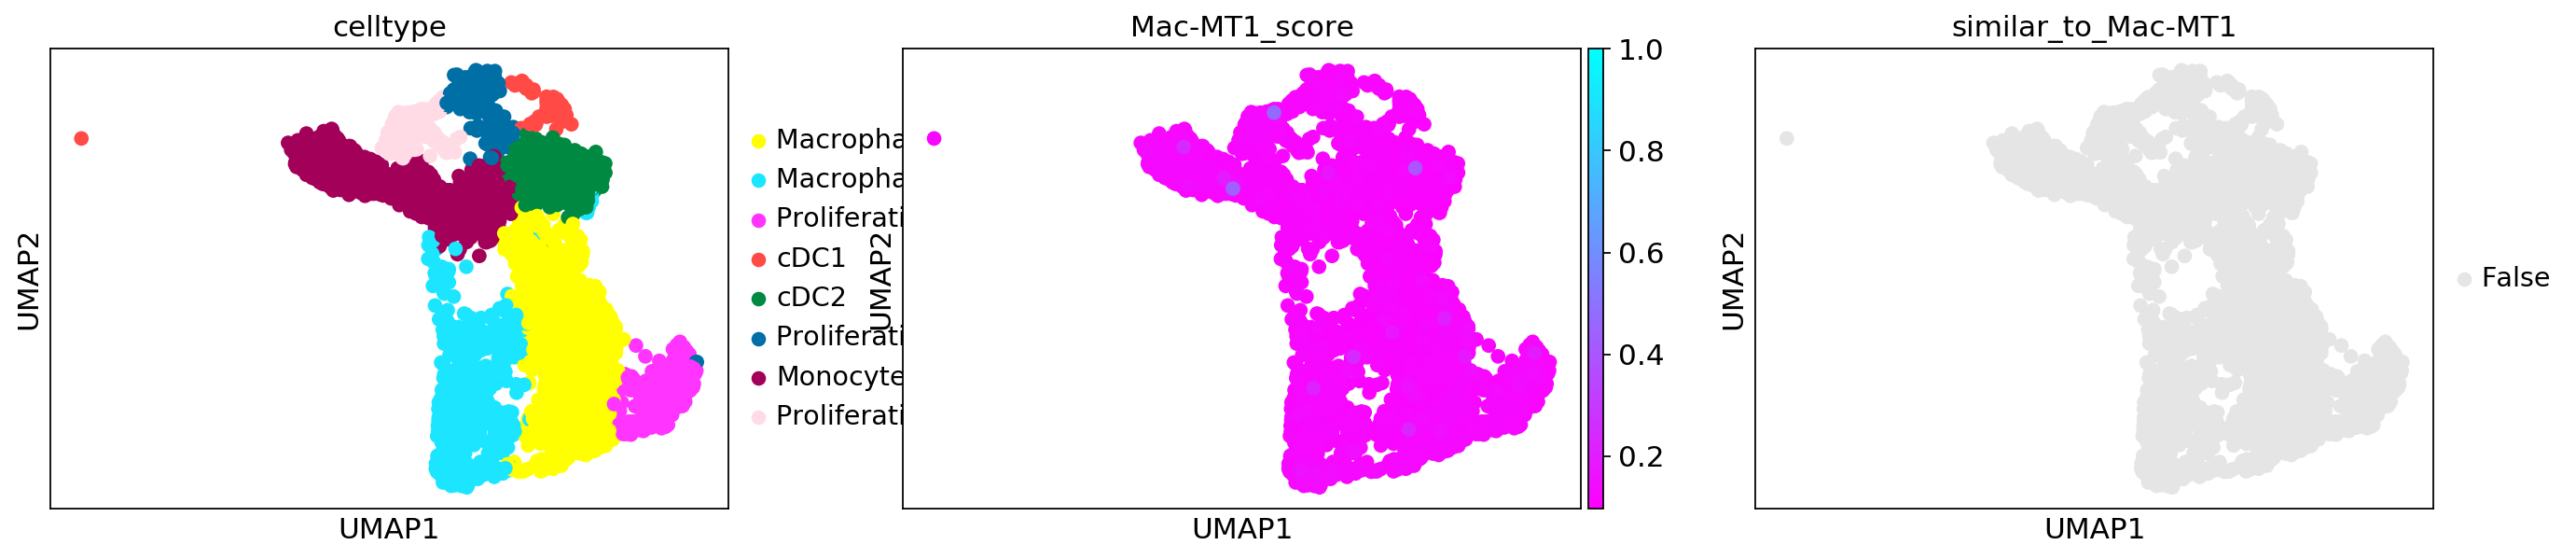

In [4]:
# now compute Mac-MT1 score p-values. figure out the global median and mad (from above-median values) for the distribution for each celltype
med = np.median(fetal.obs['Mac-MT1_score'])
mask = fetal.obs['Mac-MT1_score']>med
mad = np.median(fetal.obs['Mac-MT1_score'][mask]-med)
# do a one-sided test with Krystoff's implementation
pvals = 1-scipy.stats.norm.cdf(fetal.obs['Mac-MT1_score'], loc=med, scale=1.4826*mad)
fetal.obs['bh_pval'] = bh(pvals)
# threshold the p-values to get potential Mac-MT1 calls.
fetal.obs['similar_to_Mac-MT1'] = (fetal.obs['bh_pval'] < 0.05) & (fetal.obs['Mac-MT1_score'] > 0.5)
fetal.obs['similar_to_Mac-MT1'] = fetal.obs['similar_to_Mac-MT1'].astype('category')
# visualise the Mac-MT1
fetal.uns['similar_to_Mac-MT1_colors'] = ['#e5e5e5', '#e15759']
sc.set_figure_params(figsize = [6.0, 4.0], vector_friendly = True, dpi_save = 900)
sc.pl.umap(fetal, color = ['celltype', 'Mac-MT1_score', 'similar_to_Mac-MT1'], size = 200, save = '/kidney_fetal_similarity_to_Mac-MT1.pdf', color_map = 'cool_r', vmax =1)

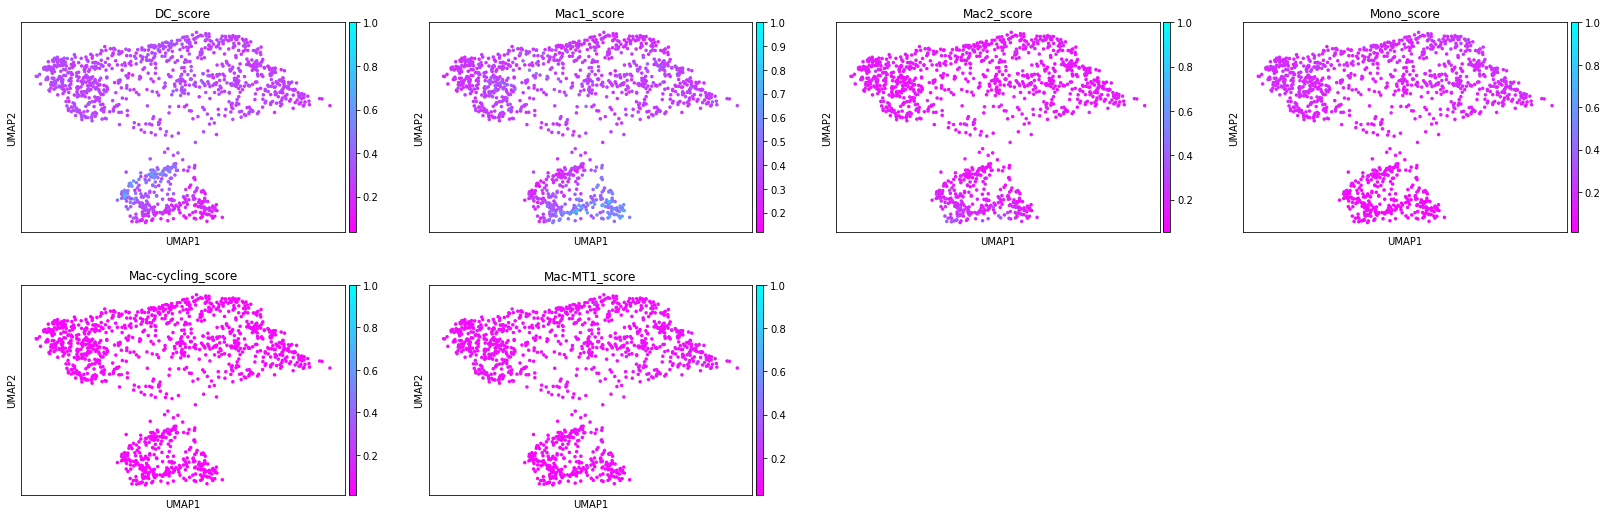

In [2]:
sc.pl.umap(mature, color = ['DC_score', 'Mac1_score', 'Mac2_score', 'Mono_score', 'Mac-cycling_score', 'Mac-MT1_score'], size =50, color_map = 'cool_r', vmax = 1)

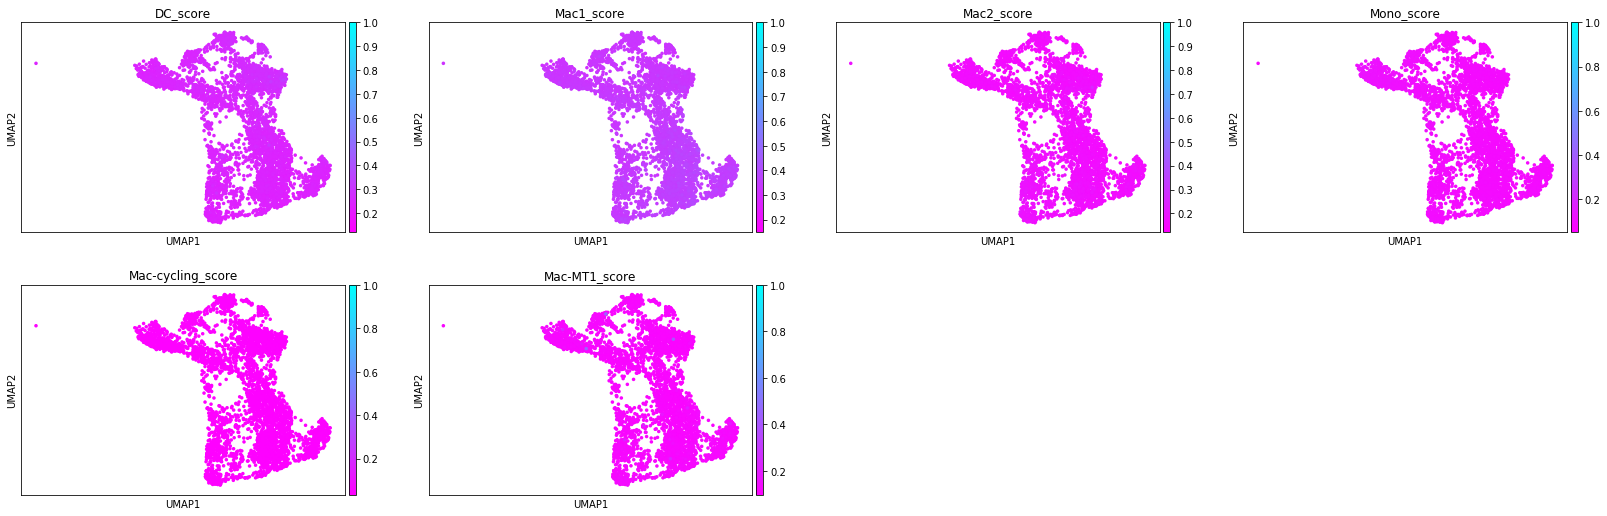

In [4]:
sc.pl.umap(fetal, color = ['DC_score', 'Mac1_score', 'Mac2_score', 'Mono_score', 'Mac-cycling_score', 'Mac-MT1_score'], size =50, color_map = 'cool_r', vmax = 1)